Building likelihood maps for a set of representative images.

> TODO: use images from dataset and superimpose the bounding boxes on them


In [1]:
import retinoto_py as fovea
subset_factor = 50
args = fovea.Params(do_fovea=True, batch_size=1, subset_factor=subset_factor)
args

Params(image_size=224, do_mask=False, do_fovea=True, rs_min=0.0, rs_max=-7.5, padding_mode='zeros', seed=2025, batch_size=1, num_workers=1, in_memory=False, model_name='convnext_base', num_epochs=41, subset_factor=50, lr=2e-07, delta1=0.2, delta2=0.007, weight_decay=0.003, label_smoothing=0.05, do_full_training=False, shuffle=True, verbose=False)

In [2]:
dataset = 'bbox'
VAL_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'val'
val_dataset = fovea.get_dataset(args, VAL_DATA_DIR, do_full_preprocess=False)
val_loader = fovea.get_loader(args, val_dataset)


In [3]:
model_filename = args.data_cache /  f'32_fovea_model_name={args.model_name}_dataset={dataset}.pth'
model = fovea.load_model(args, model_filename=model_filename)
model_filename

PosixPath('cached_data/32_fovea_model_name=convnext_base_dataset=bbox.pth')

In [4]:
from torchvision.transforms import v2 as transforms
npy_filename = args.data_cache / '42_likelihood_maps.npy'

# %rm {npy_filename}  # FORCING RECOMPUTE

In [5]:
resolution = (100, 100)
resolution = (30, 30)
resolution = (20, 20)
size_ratio = .4

if npy_filename.exists():
    likelihood_maps = fovea.np.load(npy_filename)
else:
    n_dataset = len(val_dataset)
    with fovea.torch.no_grad():
        likelihood_maps = fovea.np.empty((resolution[0], resolution[1], n_dataset))
        for i_batch, (image, true_idx) in fovea.tqdm(enumerate(val_loader), total=n_dataset):
            image, true_idx = image.to(args.device), true_idx.to(args.device)

            pos_H, pos_W, probas = fovea.compute_likelihood_map(args, model, image.squeeze(0), size_ratio=size_ratio, resolution=resolution)
            likelihood_maps[:, :, i_batch] = probas[:, true_idx].cpu().numpy().reshape(resolution)
        fovea.np.save(npy_filename, likelihood_maps)        

In [6]:
# fig, ax = fovea.plt.subplots()
# contour = ax.contourf(likelihood_maps.mean(axis=-1))
# fig.colorbar(contour, ax=ax)  # Add colorbar
# ax.axis('square')
# fig.set_facecolor(color='white')


In [7]:
likelihood_maps.shape

(20, 20, 1000)

In [8]:
i_image = 2
proba = likelihood_maps[:, :, i_image]
proba.min(), proba.max()

(np.float64(0.00027618606691248715), np.float64(0.9772347807884216))

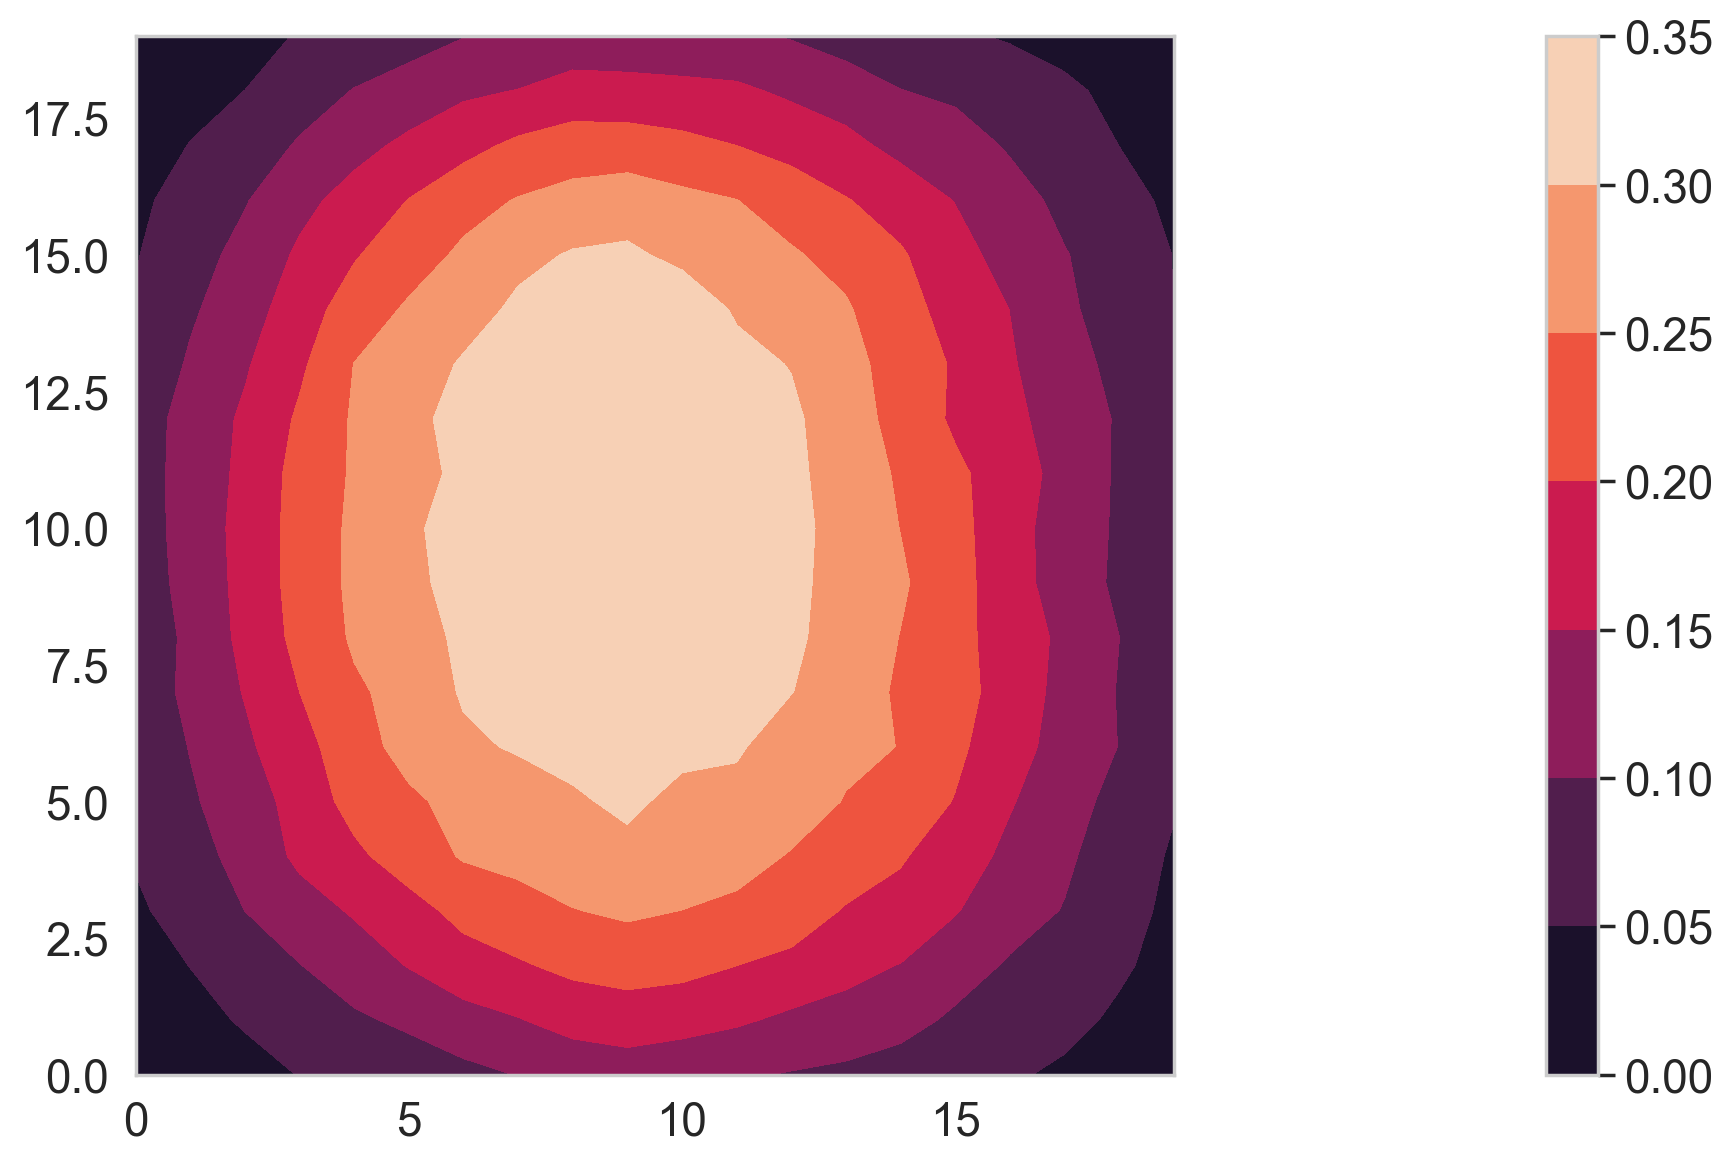

In [9]:
fig, ax = fovea.plt.subplots()
contour = ax.contourf(likelihood_maps.mean(axis=-1))
fig.colorbar(contour, ax=ax)  # Add colorbar
ax.axis('square')
fig.set_facecolor(color='white')


(array([ 47.,  26.,  14.,  23.,  31.,  39.,  27.,  60., 160., 573.]),
 array([0.00219904, 0.10143093, 0.20066281, 0.29989469, 0.39912657,
        0.49835845, 0.59759034, 0.69682222, 0.7960541 , 0.89528598,
        0.99451786]),
 <BarContainer object of 10 artists>)

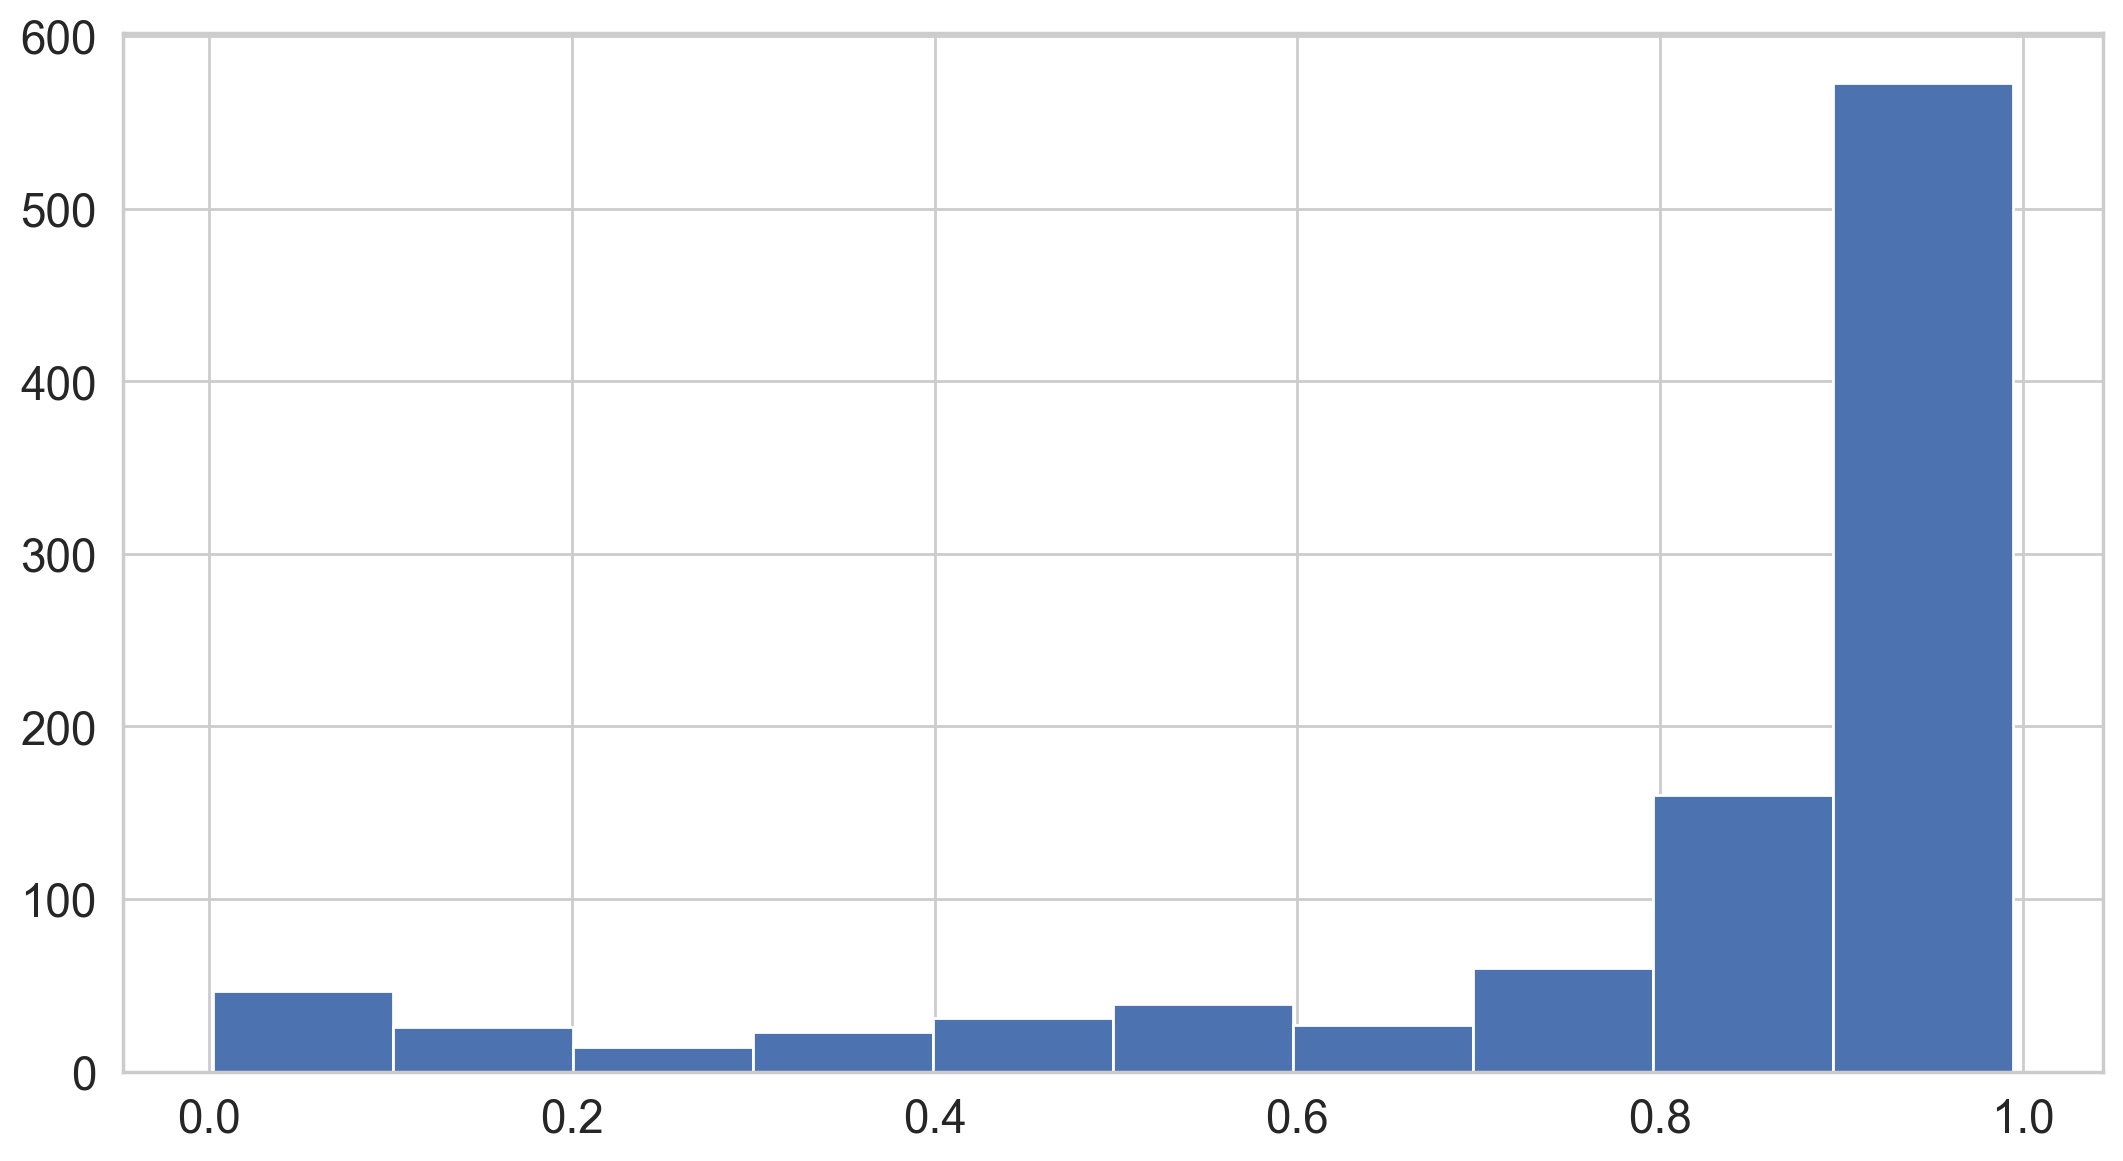

In [10]:
accuracy = likelihood_maps.max(axis=(0, 1))
fig, ax = fovea.plt.subplots()
ax.hist(accuracy)


In [11]:
import pandas as pd
import numpy as np

pos_H, pos_W = fovea.get_positions(1, 1, resolution=resolution)
pos_H.min(), pos_H.max(), pos_W.min(), pos_W.max(), pos_H.shape, likelihood_maps.shape

(np.float64(0.047619047619047616),
 np.float64(0.9523809523809523),
 np.float64(0.047619047619047616),
 np.float64(0.9523809523809523),
 (400,),
 (20, 20, 1000))

In [12]:
data = []
for do_fovea in [True, False]:    
    likelihood_maps = fovea.np.load(npy_filename)
    data_= pd.DataFrame({
        'horizontal position': pos_H,
        'vertical position': pos_W,
        'probas': likelihood_maps.mean(axis=-1).T.flatten(),
        'retinotopy': 'foveated' if do_fovea else 'uniform' 
    })
    data.append(data_)
combined_data = pd.concat(data, ignore_index=True)
combined_data

,horizontal position,vertical position,probas,retinotopy
0,0.047619,0.047619,0.010559,foveated
1,0.095238,0.047619,0.018193,foveated
2,0.142857,0.047619,0.029625,foveated
3,0.190476,0.047619,0.041835,foveated
4,0.238095,0.047619,0.054293,foveated
...,...,...,...,...
795,0.761905,0.952381,0.048930,uniform
796,0.809524,0.952381,0.042639,uniform
797,0.857143,0.952381,0.032355,uniform
798,0.904762,0.952381,0.029558,uniform


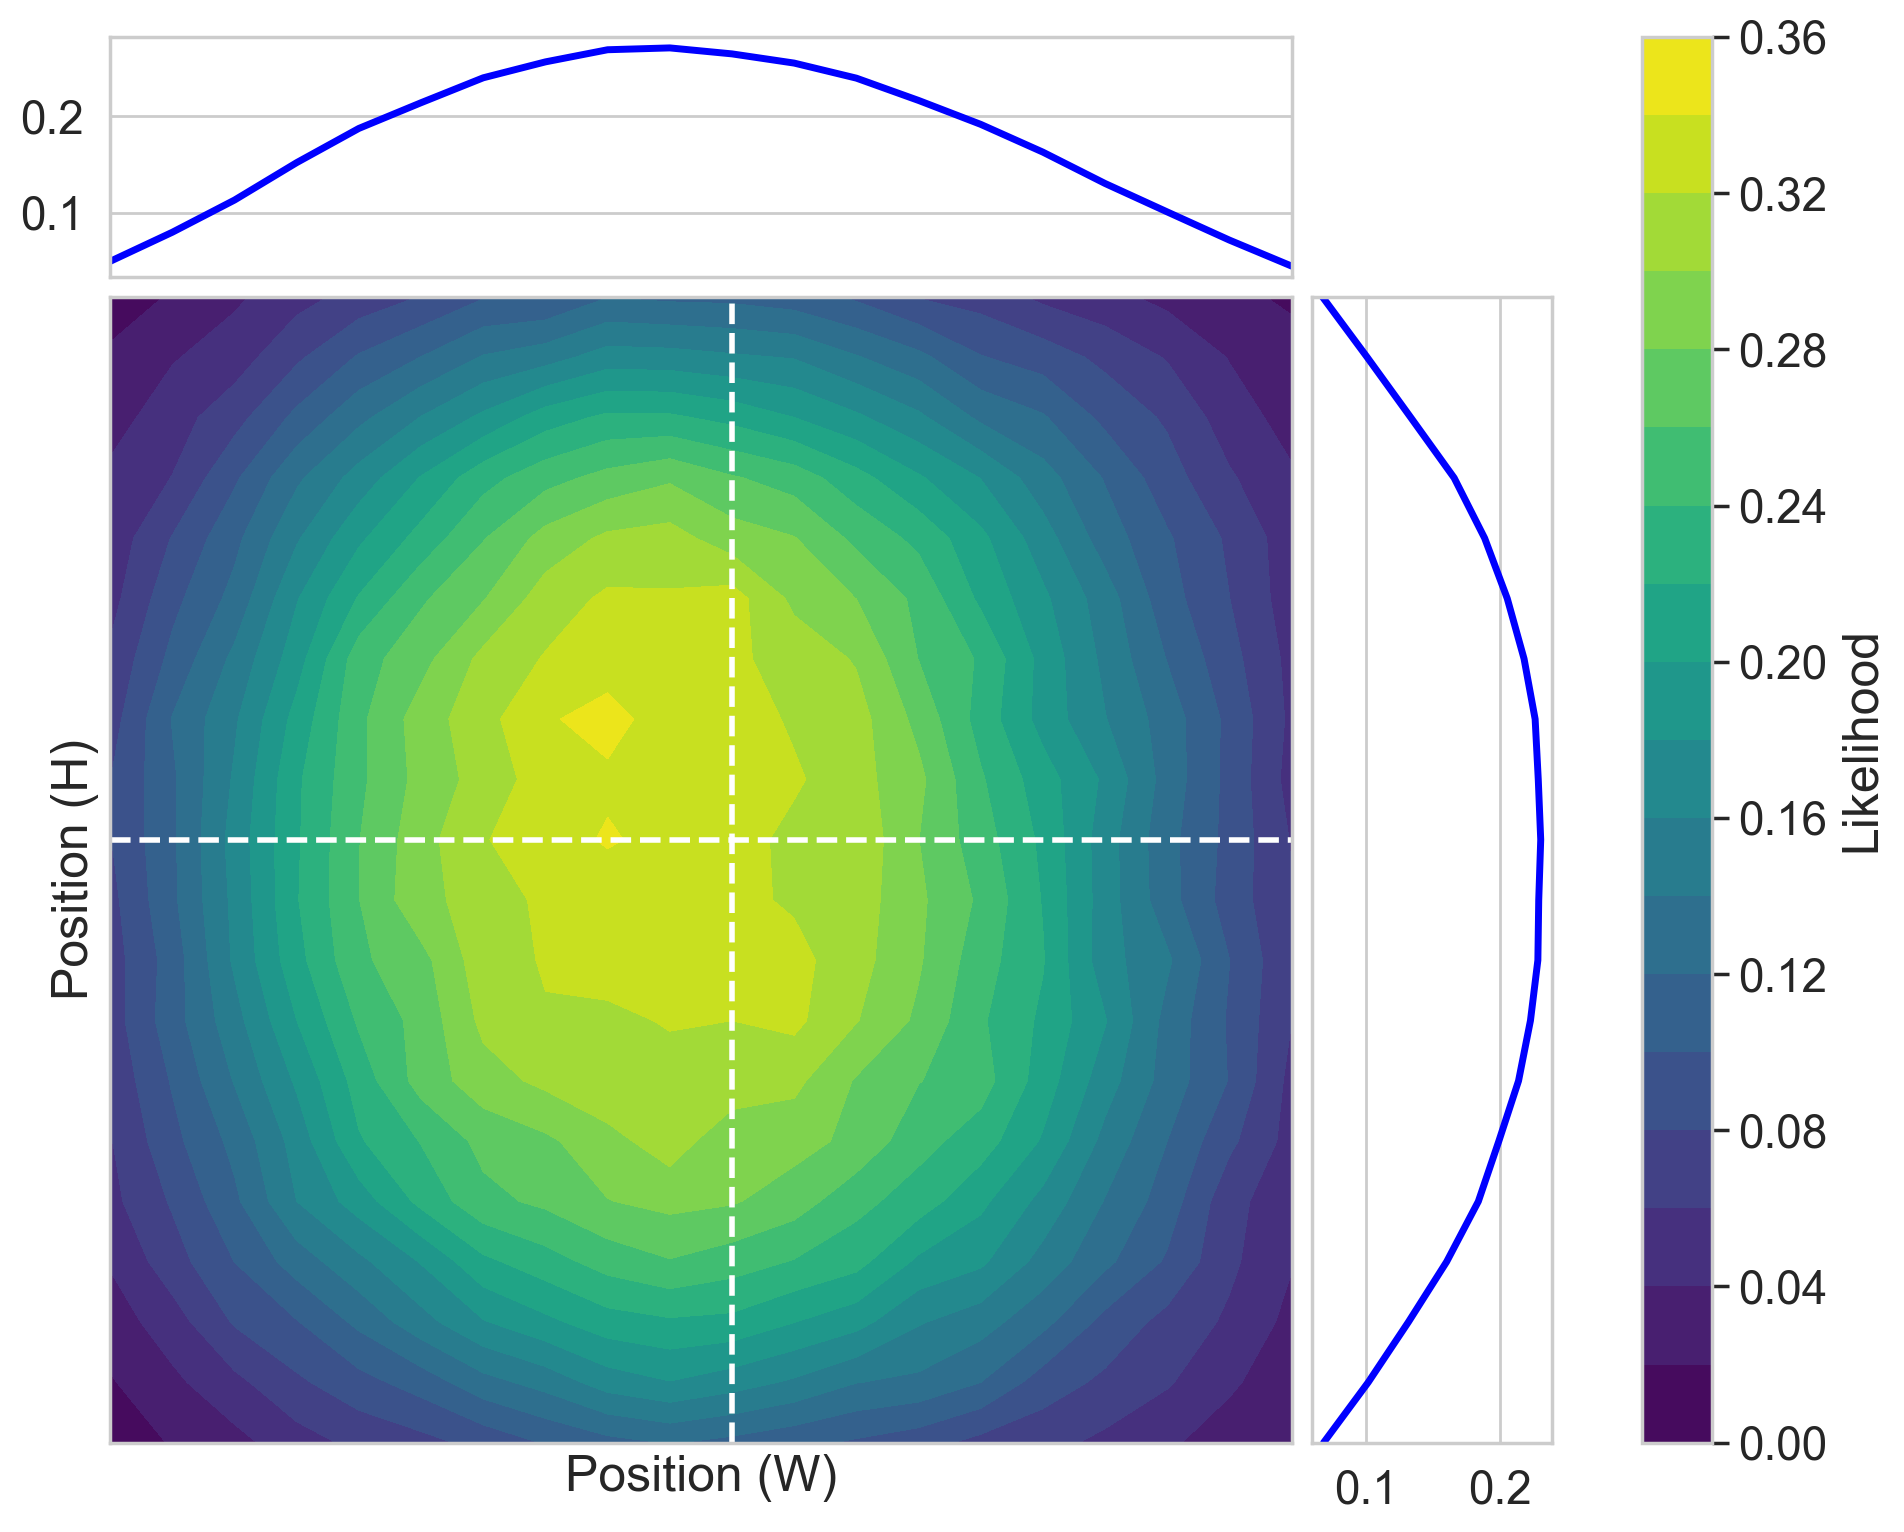

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
def visualize_likelihood_map(likelihood_map, sigma=0, color='blue', fig=None, axes=None):
    # Lisser la heatmap
    if sigma >0: likelihood_map = gaussian_filter(likelihood_map, sigma=sigma)

    # Calcul des marginales
    marginal_H = likelihood_map.mean(axis=1)  # Marginale verticale
    marginal_W = likelihood_map.mean(axis=0)  # Marginale horizontale

    # Créer la figure et l'axe principal
    fig, ax = plt.subplots(figsize=(10, 8))

    # Afficher la heatmap
    contour = ax.contourf(likelihood_map, levels=20, cmap="viridis")
    fig.colorbar(contour, ax=ax, label='Likelihood')
    # ax.set_title("Carte de probabilité de vraisemblance")
    ax.set_xlabel("Position (W)")
    ax.set_ylabel("Position (H)")

    # Ajouter une grille légère
    ax.grid(alpha=0.3, linestyle='--')

    # Ajouter les lignes centrales (verticale et horizontale)
    mid_w = likelihood_map.shape[1] / 2
    mid_h = likelihood_map.shape[0] / 2
    ax.axvline(x=mid_w, color='white', linestyle='--', linewidth=2)
    ax.axhline(y=mid_h, color='white', linestyle='--', linewidth=2)

    # Ajouter des axes pour les marginales
    divider = make_axes_locatable(ax)

    # Axe pour la marginale horizontale (en haut)
    ax_top = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
    # ax_top.plot(np.linspace(-1, 1, resolution[1]), marginal_W, color='red')
    ax_top.plot(range(resolution[1]), marginal_W, color=color)
    # ax_top.set_title("Probabilité marginale (axe horizontal)")
    # ax_top.set_ylabel("Probabilité")
    ax_top.set_xticks([])  # Pas de labels sur l'axe x pour éviter la redondance

    # Axe pour la marginale verticale (à droite)
    ax_right = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)
    # ax_right.plot(marginal_H, np.linspace(-1, 1, resolution[0]), color='blue')
    ax_right.plot(marginal_H, range(resolution[0]), color=color)
    # ax_right.set_title("Probabilité marginale (axe vertical)")
    # ax_right.set_xlabel("Probabilité")
    ax_right.set_yticks([])  # Pas de labels sur l'axe y pour éviter la redondance

    plt.tight_layout()
    axes = (ax, ax_top, ax_right)
    return fig, axes

fig, axes = visualize_likelihood_map(likelihood_maps.mean(axis=-1))
plt.show()



In [14]:
likelihood_maps.shape

(20, 20, 1000)

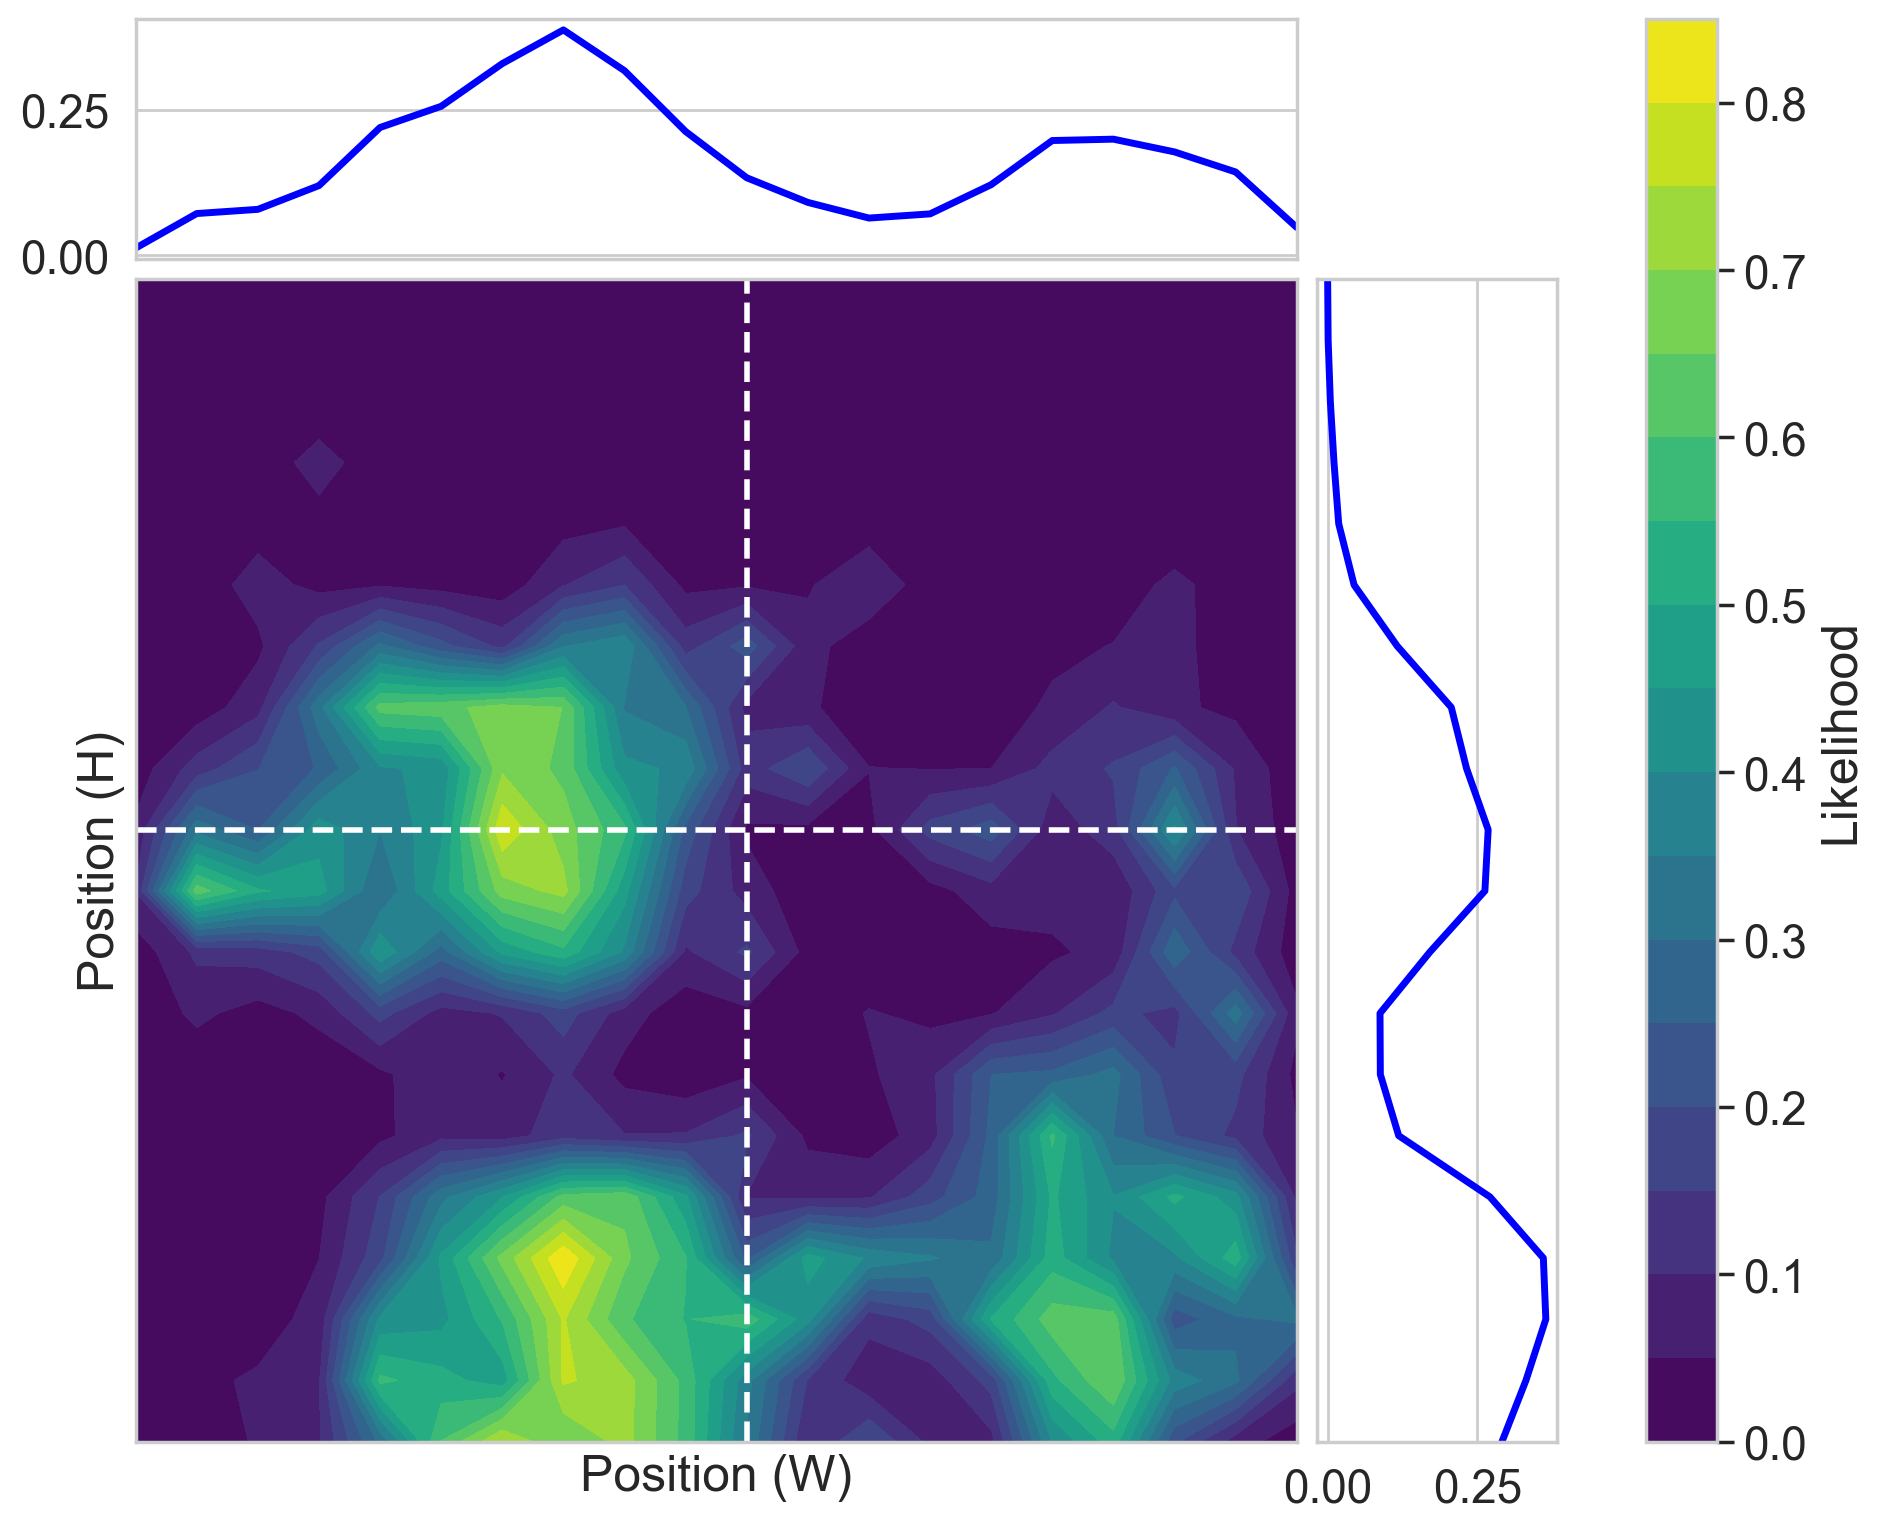

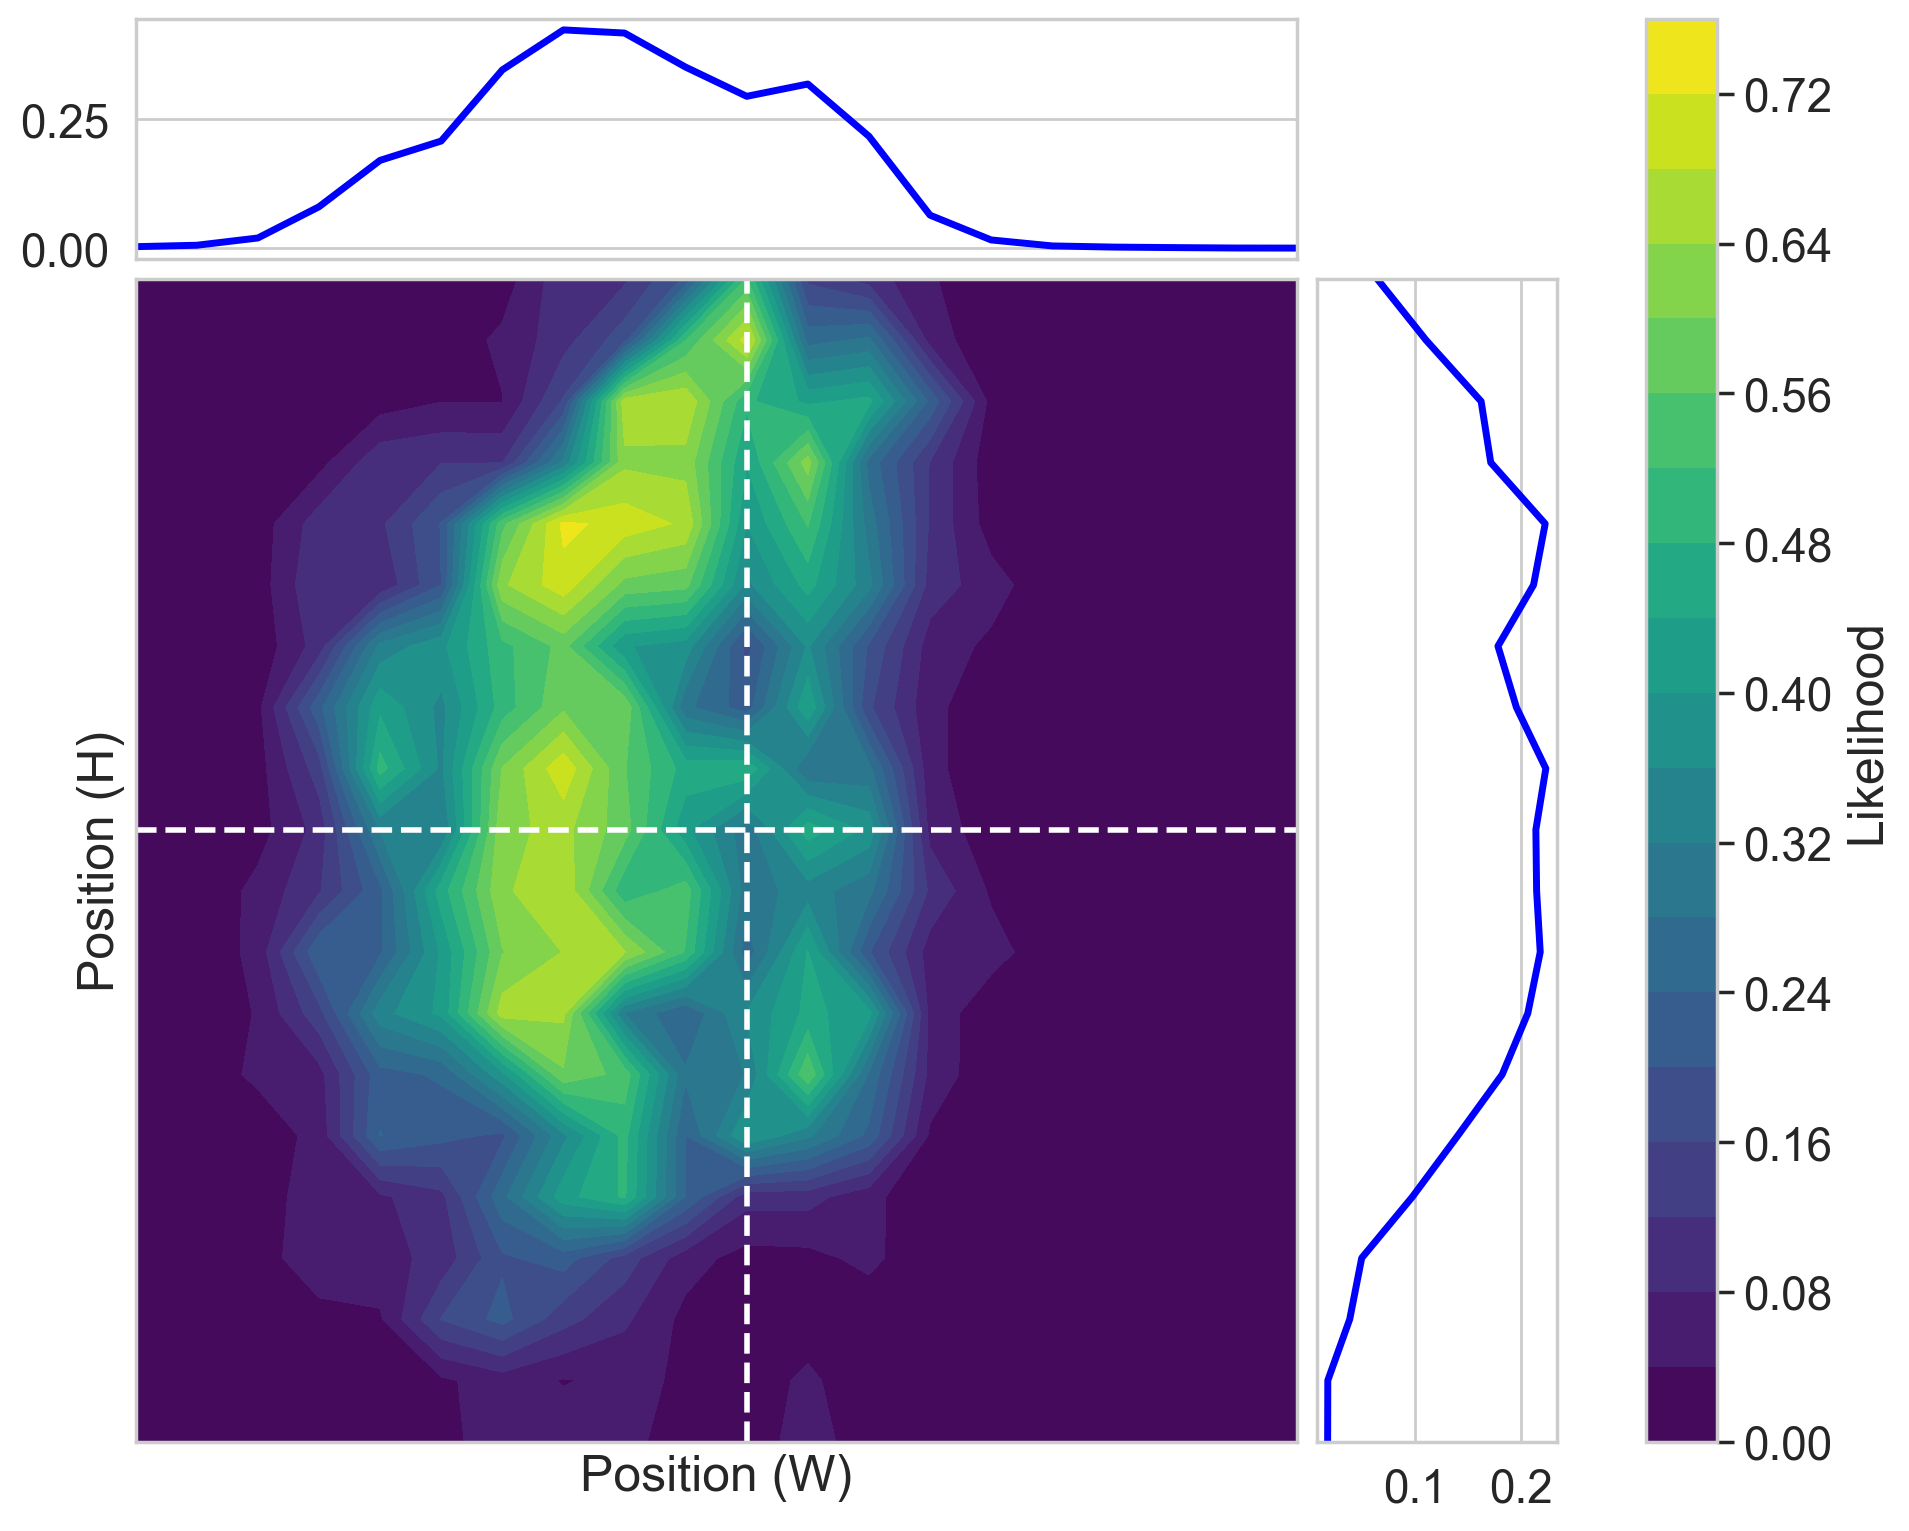

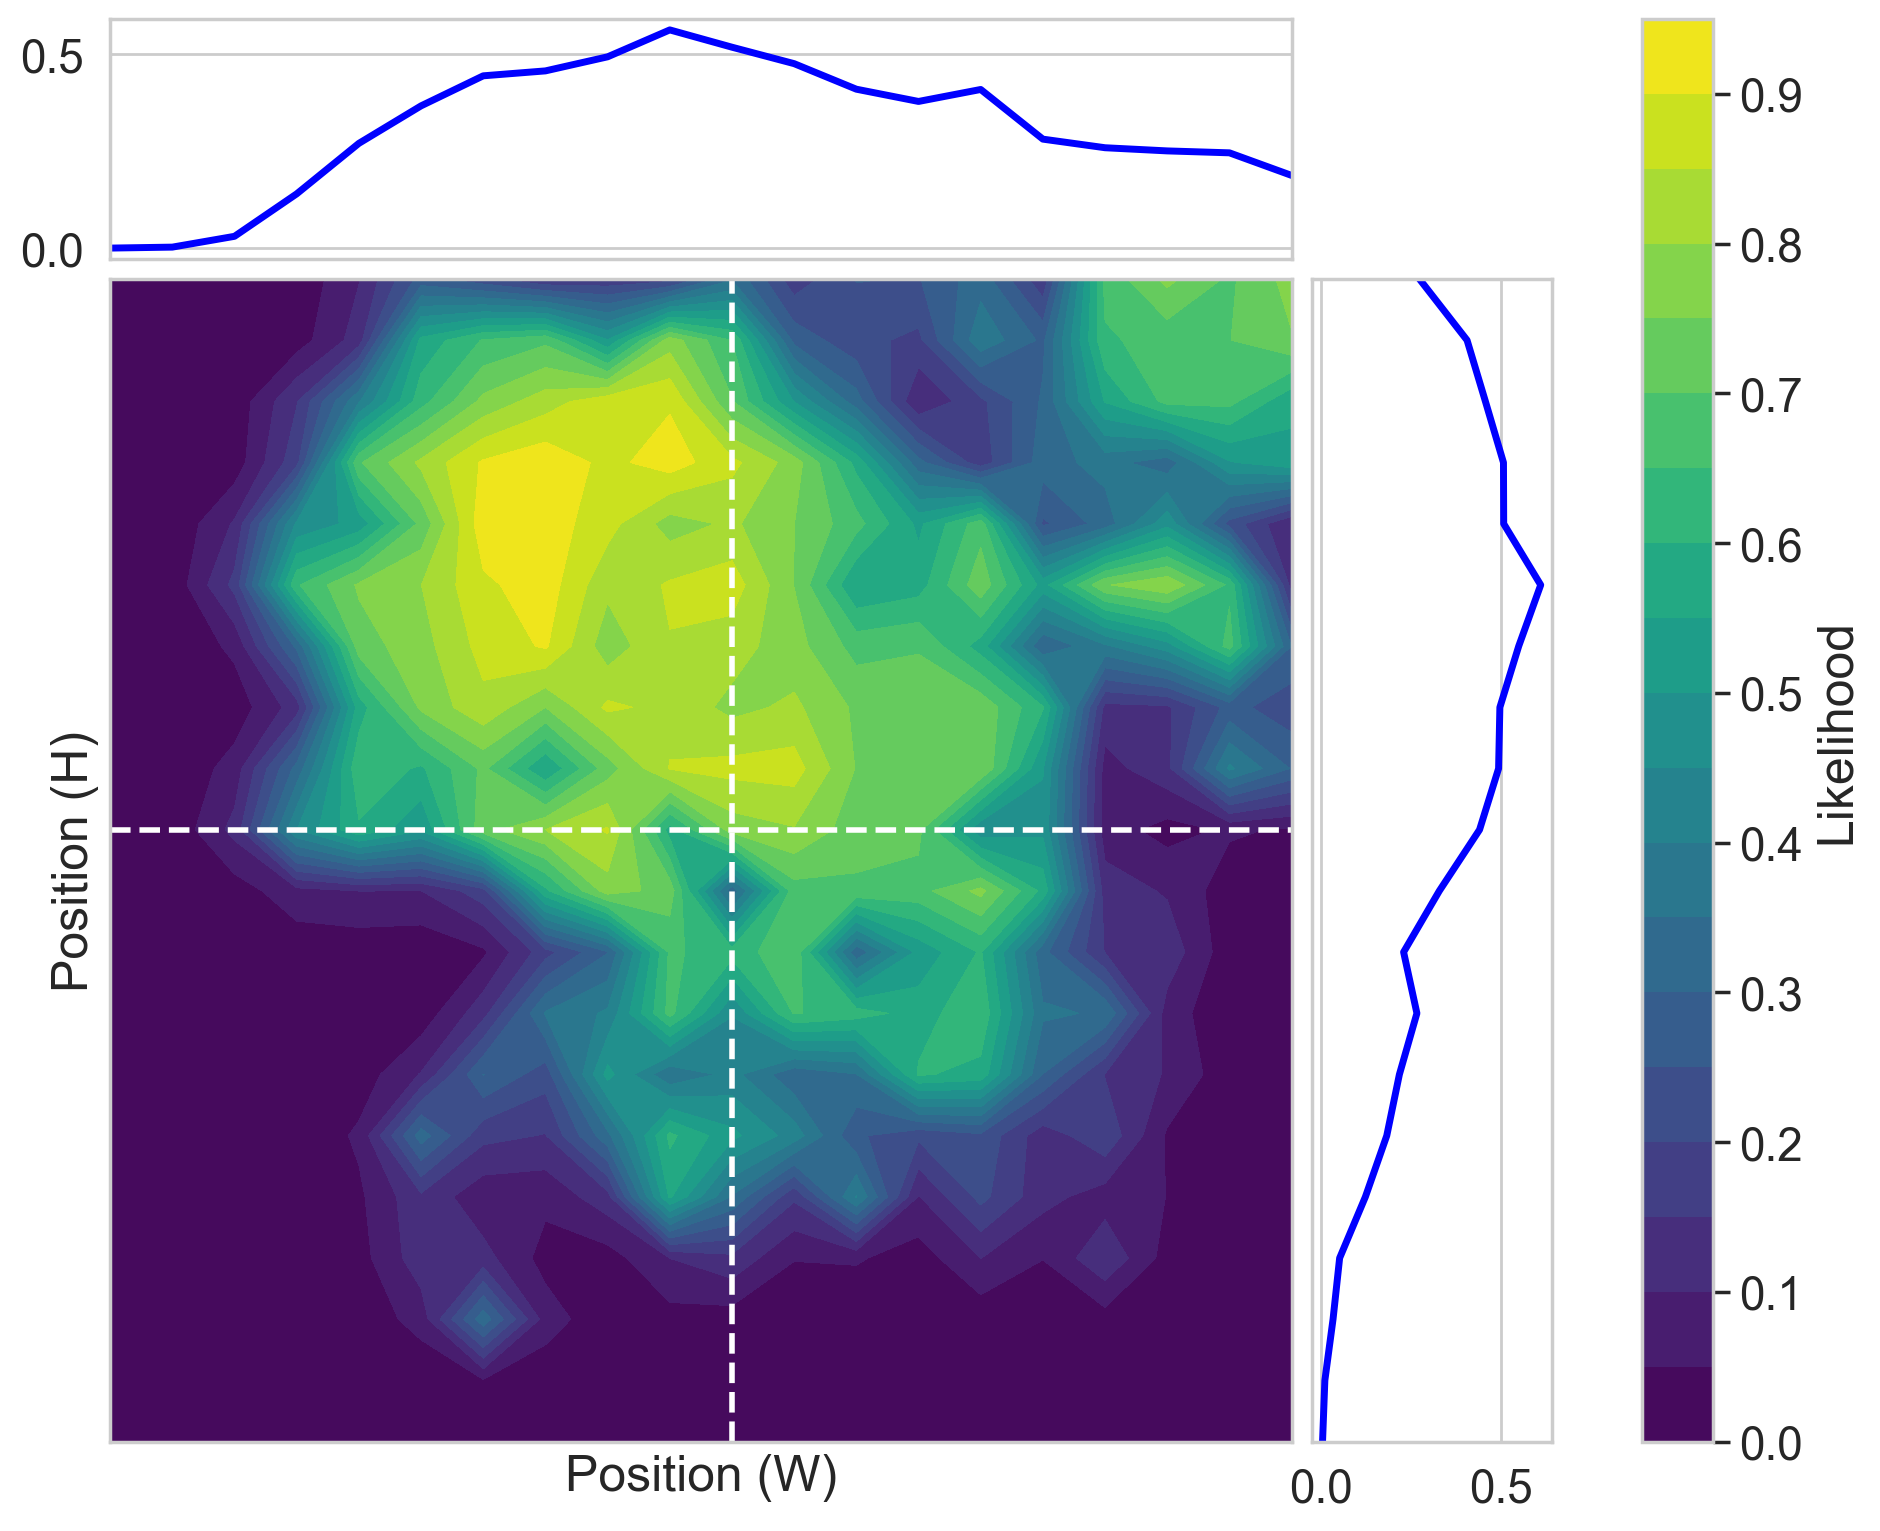

In [15]:

for i_image in [42, 23, 57]:
    fig, axes = visualize_likelihood_map(likelihood_maps[:, :, i_image], sigma=.5)
    plt.show()


In [38]:
from scipy.optimize import curve_fit

def gaussian_2d(x, y, amplitude, x0, y0, sigma_x, sigma_y, theta):
    """
    2D Gaussian function with rotation (theta).
    """
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    return amplitude * np.exp(-(a*((x-x0)**2) + 2*b*(x-x0)*(y-y0) + c*((y-y0)**2)))

from scipy.optimize import curve_fit

def fit_gaussian(likelihood_map):
    """
    Fit a 2D Gaussian to a likelihood map, constraining x0 and y0 to [-1, 1].
    Returns: amplitude, x0, y0, sigma_x, sigma_y, theta (rotation angle)
    """
    # Create a grid of coordinates
    ny, nx = likelihood_map.shape
    x = np.linspace(-1, 1, nx)
    y = np.linspace(-1, 1, ny)
    x, y = np.meshgrid(x, y)

    # Flatten the likelihood map and coordinates
    data = likelihood_map.flatten()
    x_flat = x.flatten()
    y_flat = y.flatten()

    # Initial guess for parameters
    initial_guess = (
        np.max(likelihood_map),  # amplitude
        0,                       # x0 (middle of the map)
        0,                       # y0
        0.9,                     # sigma_x
        0.9,                     # sigma_y
        0                        # theta (no rotation)
    )

    # Define bounds: (x0, y0) must be in [-1, 1]
    # Format: ([min_amp, min_x0, min_y0, min_sx, min_sy, min_theta], [max_amp, max_x0, max_y0, max_sx, max_sy, max_theta])
    bounds = (
        [-np.inf, -1, -1, 0.01, 0.01, -np.pi],  # Lower bounds
        [np.inf, 1, 1, 2, 2, np.pi]            # Upper bounds
    )

    # Fit the Gaussian with bounds
    try:
        popt, pcov = curve_fit(
            lambda arr, amp, x0, y0, sx, sy, theta:
                gaussian_2d(arr[0], arr[1], amp, x0, y0, sx, sy, theta),
            (x_flat, y_flat),
            data,
            p0=initial_guess,
            bounds=bounds,
            maxfev=100000
        )
        return popt
    except RuntimeError:
        # If fitting fails, return NaN values
        return np.full(6, np.nan)

import pandas as pd

def compute_gaussian_params(likelihood_maps):
    """
    Compute Gaussian parameters for each likelihood map in `likelihood_maps`.
    `likelihood_maps` shape: (height, width, n_images)
    Returns: pandas DataFrame with columns for each parameter
    """
    n_images = likelihood_maps.shape[-1]
    results = {
        'image_index': [],
        'amplitude': [],
        'x0': [],
        'y0': [],
        'sigma_x': [],
        'sigma_y': [],
        'theta': []
    }

    for i_image in fovea.tqdm(range(n_images)):
        likelihood_map = likelihood_maps[:, :, i_image]
        # Smooth the map to reduce noise
        likelihood_map = gaussian_filter(likelihood_map, sigma=1)
        # Fit the Gaussian
        gaussian_params = fit_gaussian(likelihood_map)

        # Append results to the dictionary
        results['image_index'].append(i_image)
        results['amplitude'].append(gaussian_params[0])
        results['x0'].append(gaussian_params[1])
        results['y0'].append(gaussian_params[2])
        results['sigma_x'].append(gaussian_params[3])
        results['sigma_y'].append(gaussian_params[4])
        results['theta'].append(gaussian_params[5])

    # Convert the dictionary to a pandas DataFrame
    df = pd.DataFrame(results)
    return df


# Example usage:
gaussian_df = compute_gaussian_params(likelihood_maps)
gaussian_df.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

,image_index,amplitude,x0,y0,sigma_x,sigma_y,theta
0,0,0.630898,-0.148478,0.653564,0.372093,1.477443,0.181883
1,1,0.819108,0.193700,0.107668,0.296321,1.548728,-0.556812
2,2,0.801343,0.060394,-0.075405,0.427561,2.000000,0.111113
3,3,0.629862,-0.059113,-0.435016,0.862076,0.509972,2.383523
4,4,0.080500,0.052693,-0.572278,0.202746,0.363452,-1.194010


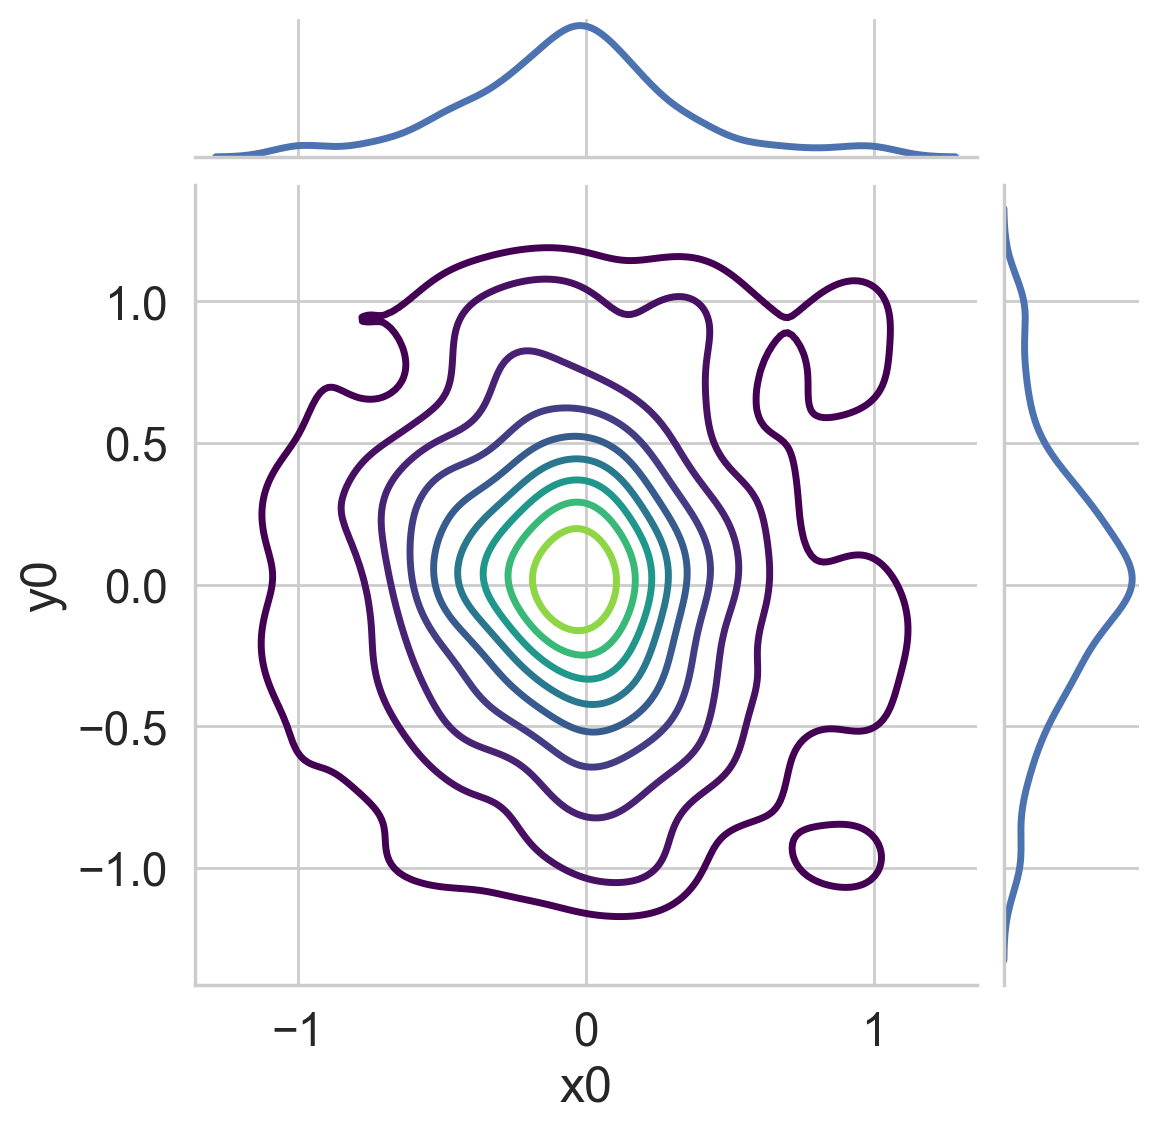

In [ ]:
# Joint KDE plot with marginals
g = sns.jointplot(
    data=gaussian_df,
    x="x0",
    y="y0",
    kind="kde",
    cmap="viridis",
)
plt.show()

In [ ]:
# Example: Check if sigma_x is usually bigger than sigma_y
is_sigma_x_bigger = gaussian_df["sigma_x"] > gaussian_df["sigma_y"]
print(f"Fraction of images where sigma_x > sigma_y (more horizontal): {is_sigma_x_bigger.mean():.2f}")
print(f"Fraction of images where sigma_y > sigma_x (more vertical): {(~is_sigma_x_bigger).mean():.2f}")

Fraction of images where sigma_x > sigma_y: 0.43
Fraction of images where sigma_y > sigma_x: 0.57


In [81]:
import numpy as np
import lmfit
from lmfit import Parameters, minimize, report_fit

def gaussian_2d_lmfit(params, x, y, data):
    """
    2D Gaussian function for lmfit.
    """
    amp = params['amplitude']
    x0 = params['x0']
    y0 = params['y0']
    sx = params['sigma_x']
    sy = params['sigma_y']
    theta = params['theta']

    a = (np.cos(theta)**2)/(2*sx**2) + (np.sin(theta)**2)/(2*sy**2)
    b = -(np.sin(2*theta))/(4*sx**2) + (np.sin(2*theta))/(4*sy**2)
    c = (np.sin(theta)**2)/(2*sx**2) + (np.cos(theta)**2)/(2*sy**2)

    model = amp * np.exp(-(a*((x-x0)**2) + 2*b*(x-x0)*(y-y0) + c*((y-y0)**2)))
    return model - data  # Residuals for least-squares minimization

def fit_gaussian_lmfit(likelihood_map):
    """
    Fit a 2D Gaussian to a likelihood map using lmfit, constraining x0 and y0 to [-1, 1].
    Returns: amplitude, x0, y0, sigma_x, sigma_y, theta (rotation angle)
    """
    # Create a grid of coordinates
    ny, nx = likelihood_map.shape
    x = np.linspace(-1, 1, nx)
    y = np.linspace(-1, 1, ny)
    x, y = np.meshgrid(x, y)

    # Flatten the likelihood map and coordinates
    data = likelihood_map.flatten()
    x_flat = x.flatten()
    y_flat = y.flatten()

    # Create Parameters object with initial guesses and bounds
    params = lmfit.Parameters()
    params.add('amplitude', value=np.max(likelihood_map), min=0)  # Amplitude must be positive
    params.add('x0', value=0, min=-1, max=1)  # x0 in [-1, 1]
    params.add('y0', value=0, min=-1, max=1)  # y0 in [-1, 1]
    params.add('sigma_x', value=0.5, min=0.01, max=4)  # sigma_x bounds
    params.add('sigma_y', value=0.5, min=0.01, max=4)  # sigma_y bounds
    params.add('theta', value=0, min=-np.pi/2, max=np.pi/2)  # theta bounds

    # Minimize the residuals using least-squares
    result = minimize(
        gaussian_2d_lmfit,
        params,
        args=(x_flat, y_flat, data),
        # method='leastsq',  # Levenberg-Marquardt algorithm
        method='lbfgsb',
        tol=1e-8,
        # xtol=1e-8,
        max_nfev=20000
    )

    # Check if the fit succeeded
    if not result.success:
        return np.full(6, np.nan)

    fit_result = {}
    for name, param in result.params.items():
        fit_result[name] = param.value
        # fit_result[f"{name}_error"] = param.stderr

    return fit_result


def compute_gaussian_params(likelihood_maps, sigma=.5):
    """
    Compute Gaussian parameters for each likelihood map in `likelihood_maps`.
    `likelihood_maps` shape: (height, width, n_images)
    Returns: pandas DataFrame with columns for each parameter
    """
    n_images = likelihood_maps.shape[-1]
    results = []

    for i_image in fovea.tqdm(range(n_images)):
        likelihood_map = likelihood_maps[:, :, i_image]
        # Smooth the map to reduce noise
        likelihood_map = gaussian_filter(likelihood_map, sigma=sigma)
        # Fit the Gaussian
        results.append(fit_gaussian_lmfit(likelihood_map))


    # Convert the dictionary to a pandas DataFrame
    gaussian_df = pd.DataFrame(results)
    gaussian_df["theta_deg"] = np.rad2deg(gaussian_df["theta"])
    gaussian_df['sigma_major'] = np.where(gaussian_df['sigma_x'] > gaussian_df['sigma_y'], 
                                          gaussian_df['sigma_x'], gaussian_df['sigma_y'])
    gaussian_df['sigma_minor'] = np.where(gaussian_df['sigma_x'] < gaussian_df['sigma_y'], 
                                          gaussian_df['sigma_x'], gaussian_df['sigma_y'])

    gaussian_df["elongation"] = gaussian_df['sigma_major'] / gaussian_df['sigma_minor']
    return gaussian_df
gaussian_df = compute_gaussian_params(likelihood_maps, sigma=.5)
gaussian_df.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

,amplitude,x0,y0,sigma_x,sigma_y,theta,theta_deg,sigma_major,sigma_minor,elongation
0,0.664527,-0.151929,0.613105,0.350715,1.383818,0.191047,10.946199,1.383818,0.350715,3.945709
1,0.873911,0.195036,0.100144,0.279417,1.450423,-0.560669,-32.123940,1.450423,0.279417,5.190900
2,0.794925,0.039387,-0.258678,0.418429,4.000000,0.107141,6.138742,4.000000,0.418429,9.559556
3,0.651126,-0.060090,-0.427205,0.497762,0.829954,0.830316,47.573611,0.829954,0.497762,1.667370
4,0.470493,0.257153,-0.653982,0.074750,0.055802,1.570796,90.000000,0.074750,0.055802,1.339570


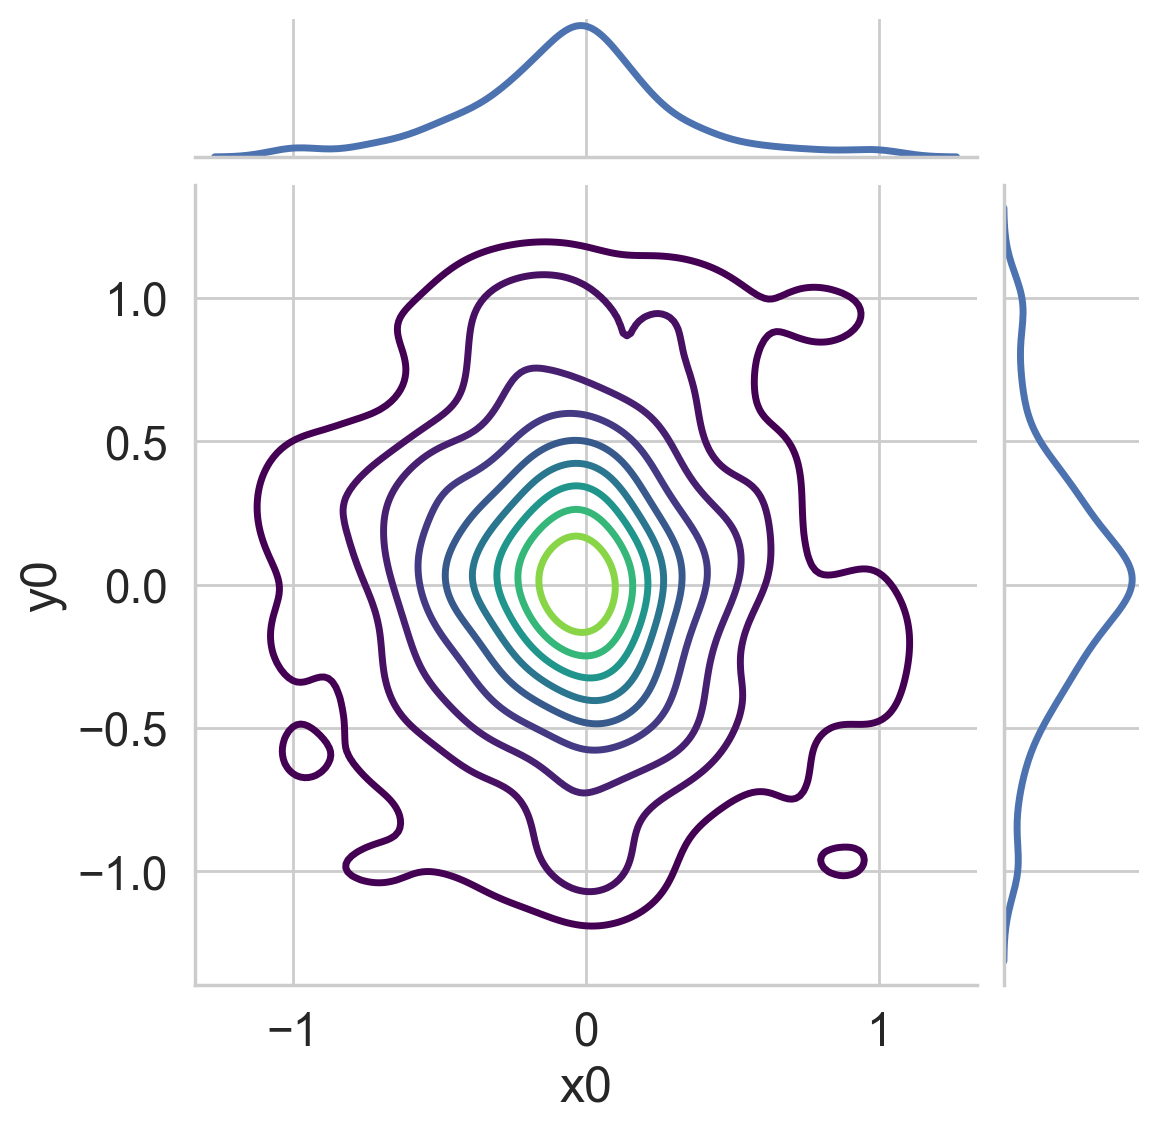

In [82]:
# Joint KDE plot with marginals
g = sns.jointplot(
    data=gaussian_df,
    x="x0",
    y="y0",
    kind="kde",
    cmap="viridis",
)
plt.show()

/Users/laurent/app54_nextcloud/science/retinoto_py/.venv/lib/python3.14/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


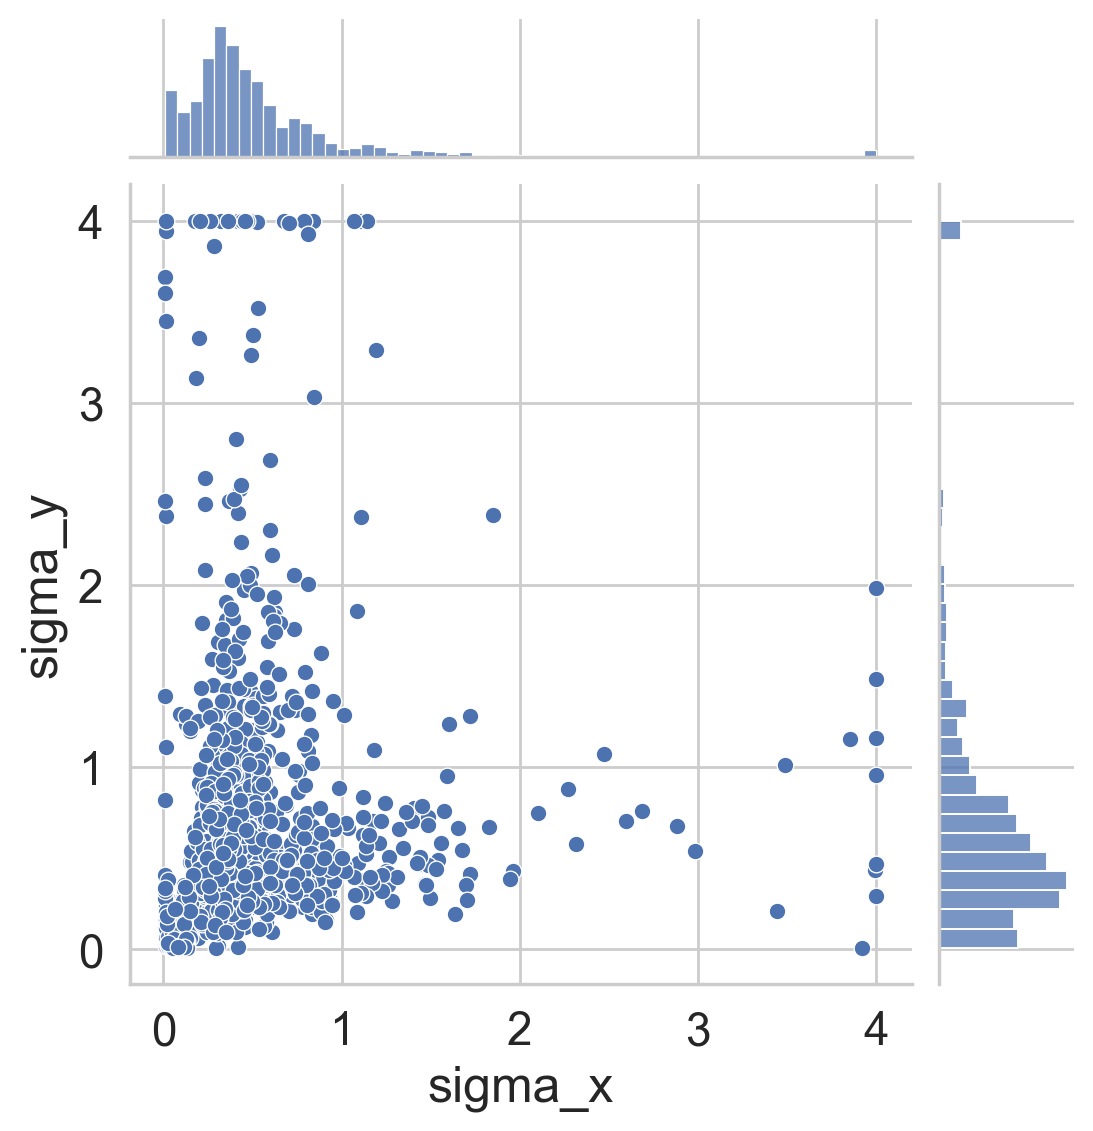

In [83]:
# Joint KDE plot with marginals
g = sns.jointplot(
    data=gaussian_df,
    x="sigma_x",
    y="sigma_y",
    kind="scatter",
    cmap="viridis",
)
plt.show()

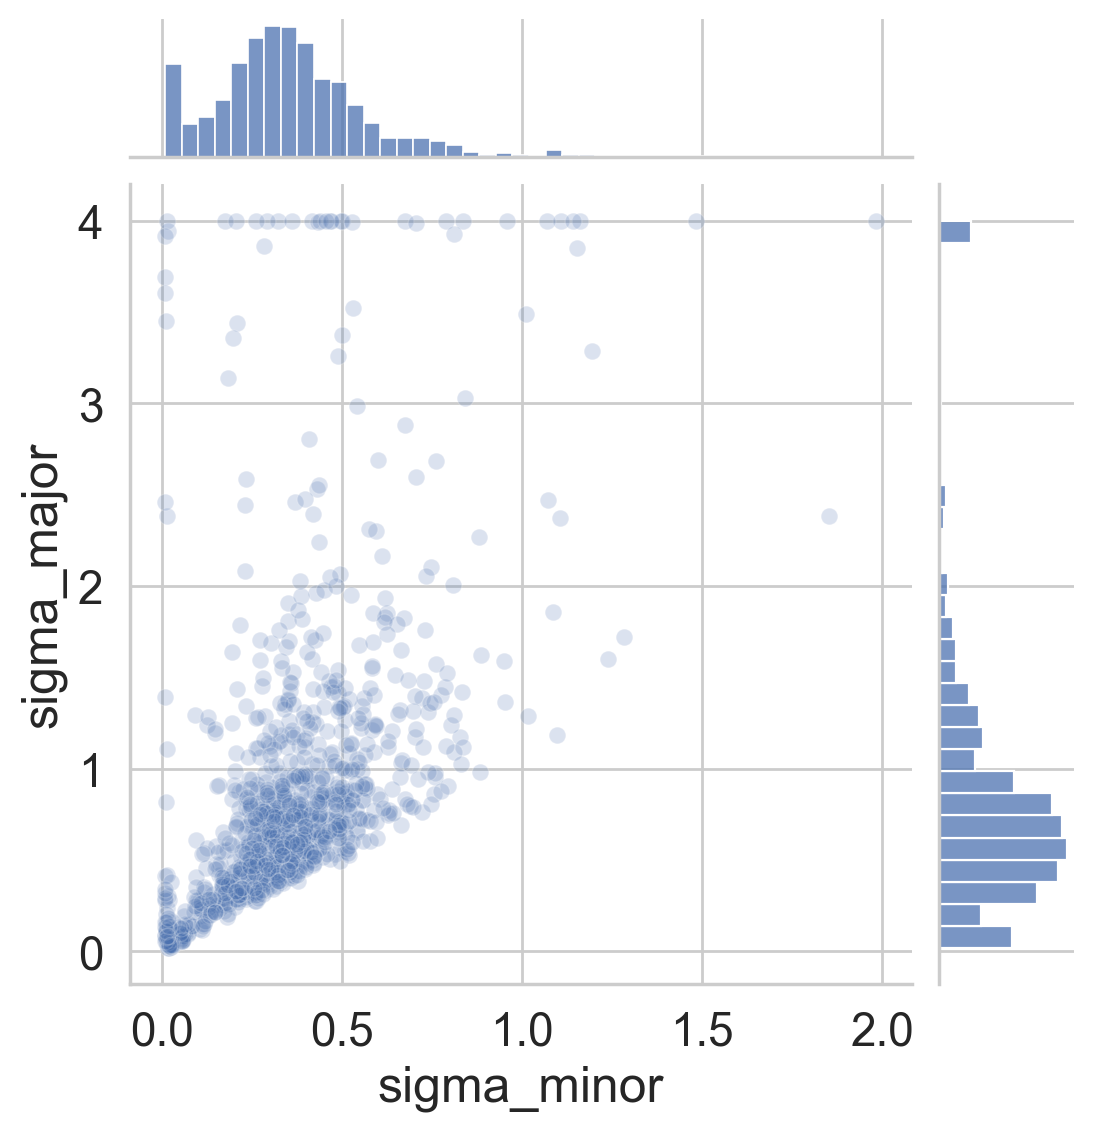

In [84]:
# Joint KDE plot with marginals
g = sns.jointplot(
    data=gaussian_df,
    x="sigma_minor",
    y="sigma_major",
    kind="scatter",
    alpha=.2,
)
plt.show()

Text(4, 120, ' Peak @ 1.96')

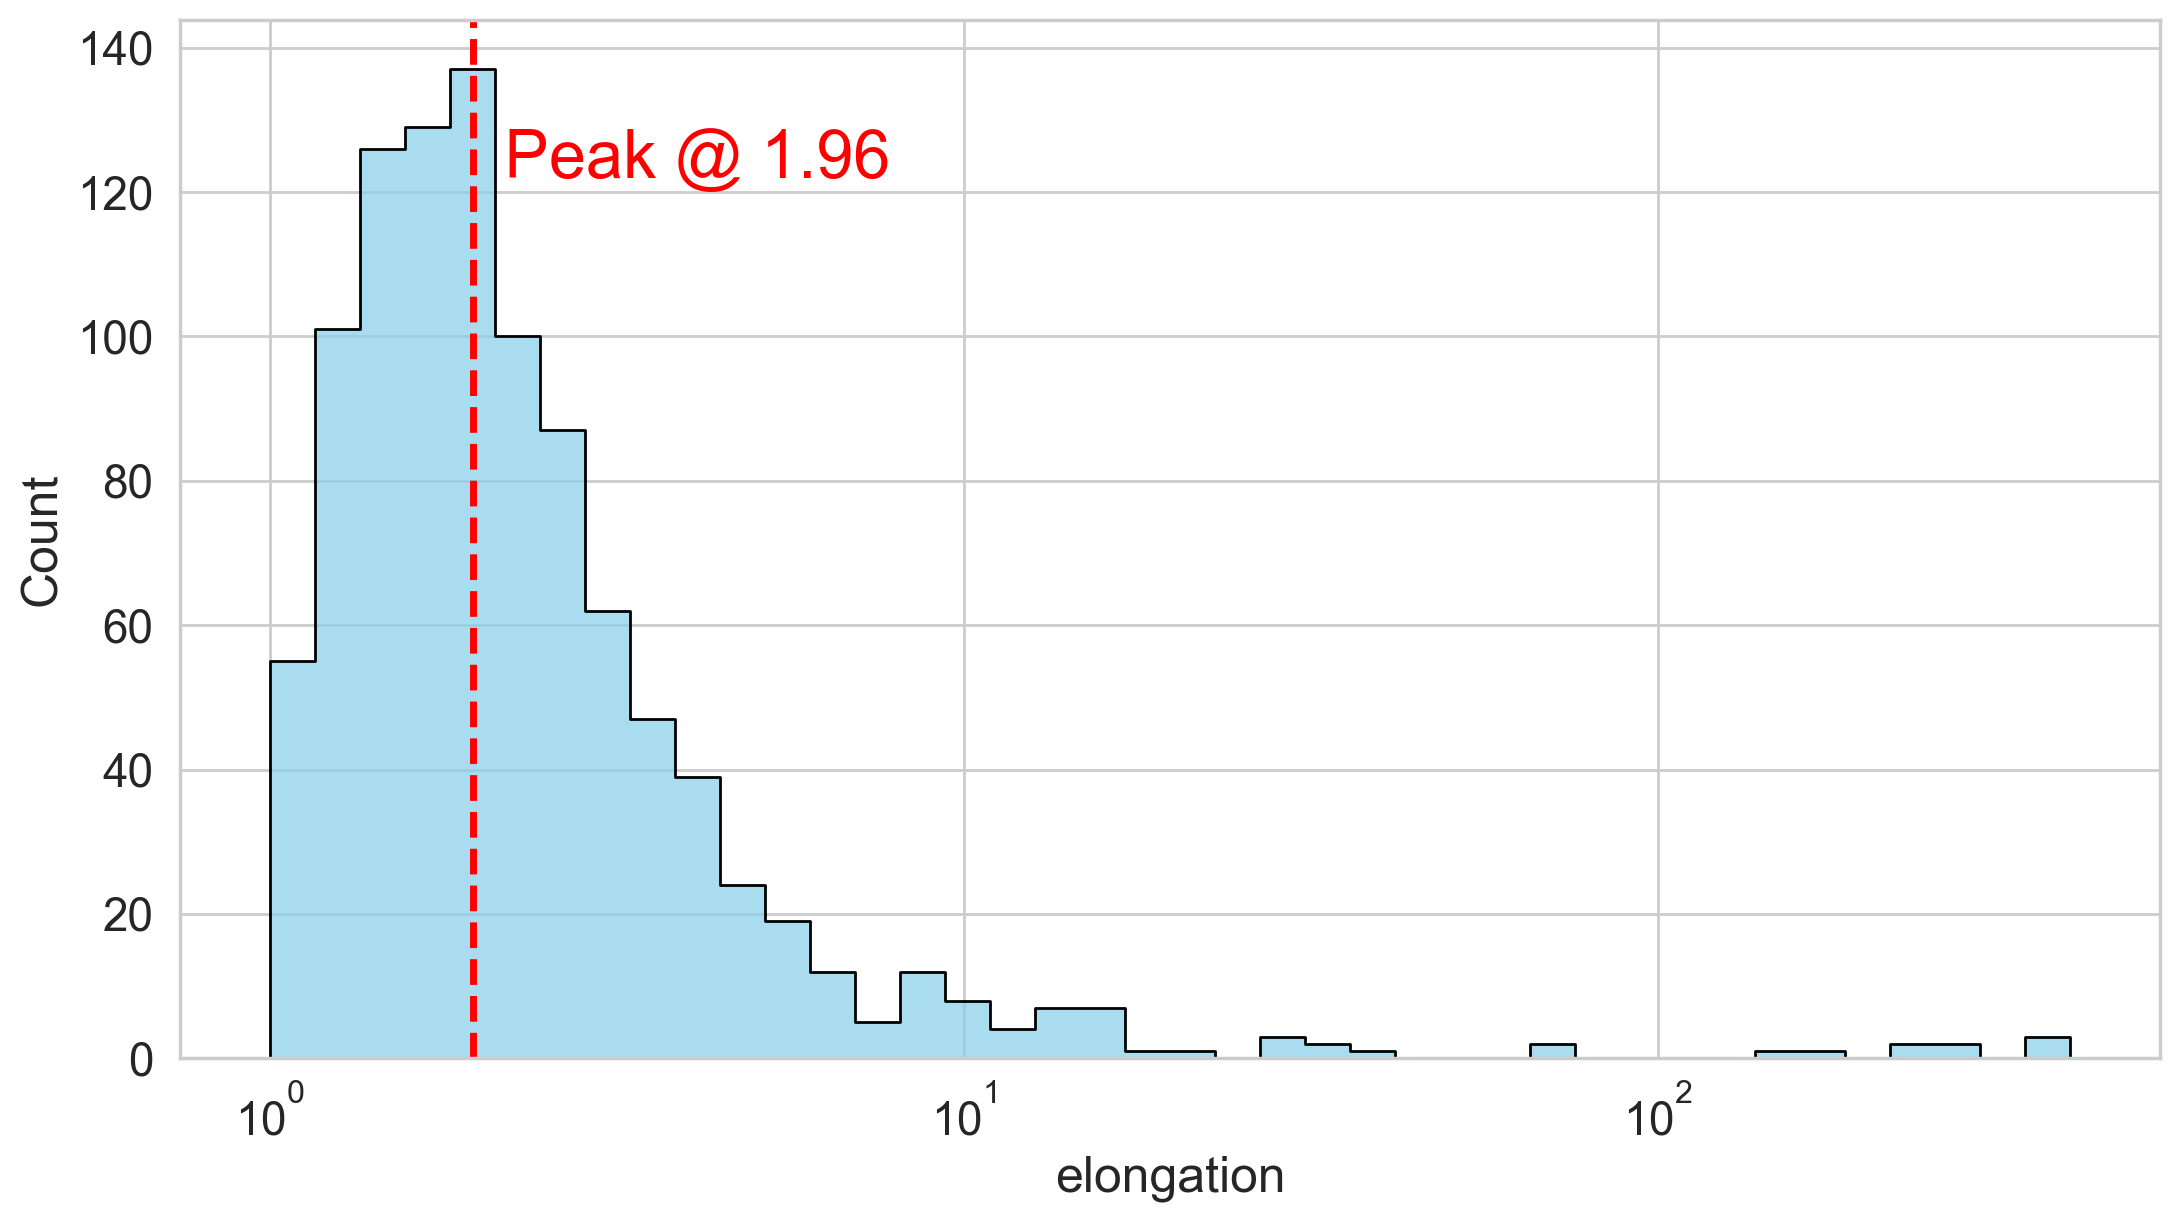

In [99]:
sns.histplot(
    data=gaussian_df,
    x='elongation',
    bins=40,
    element='step',  # Use step plots for clarity
    kde=False,  # Disable KDE for log-scaled x-axis
    color='skyblue',
    alpha=0.7,
    edgecolor='black',
    log_scale=(True, False)  # Log scale only for the x-axis
)

# Compute the peak (bin with the highest count)
counts, bin_edges = np.histogram(np.log(gaussian_df['elongation']), bins=40)
peak_bin_index = np.argmax(counts)
log_peak_value = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2  # Midpoint of the peak bin
peak_count = counts[peak_bin_index]
peak_value = np.exp(log_peak_value)

# Annotate the peak on the plot
plt.axvline(x=peak_value, color='red', linestyle='--', label=f'Peak: {peak_value:.2f}')
plt.text(
    4,
    120,
    f' Peak @ {peak_value:.2f}',
    ha='center',
    va='bottom',
    color='red',
    fontsize=24,
    bbox=dict(facecolor='white', alpha=0., edgecolor='none')
)

In [93]:
counts, bin_edges

(array([962,  20,   4,   2,   1,   0,   0,   2,   0,   0,   0,   0,   0,
          0,   1,   0,   0,   1,   0,   0,   0,   0,   0,   0,   1,   1,
          1,   0,   0,   1,   0,   0,   0,   0,   0,   0,   1,   1,   0,
          1]),
 array([  1.00036868,  10.77296414,  20.5455596 ,  30.31815506,
         40.09075052,  49.86334598,  59.63594144,  69.4085369 ,
         79.18113236,  88.95372782,  98.72632328, 108.49891874,
        118.2715142 , 128.04410966, 137.81670512, 147.58930058,
        157.36189604, 167.1344915 , 176.90708696, 186.67968242,
        196.45227788, 206.22487334, 215.9974688 , 225.77006426,
        235.54265972, 245.31525518, 255.08785064, 264.8604461 ,
        274.63304156, 284.40563702, 294.17823248, 303.95082794,
        313.7234234 , 323.49601886, 333.26861432, 343.04120978,
        352.81380524, 362.5864007 , 372.35899616, 382.13159162,
        391.90418708]))

<Axes: xlabel='theta_deg', ylabel='Count'>

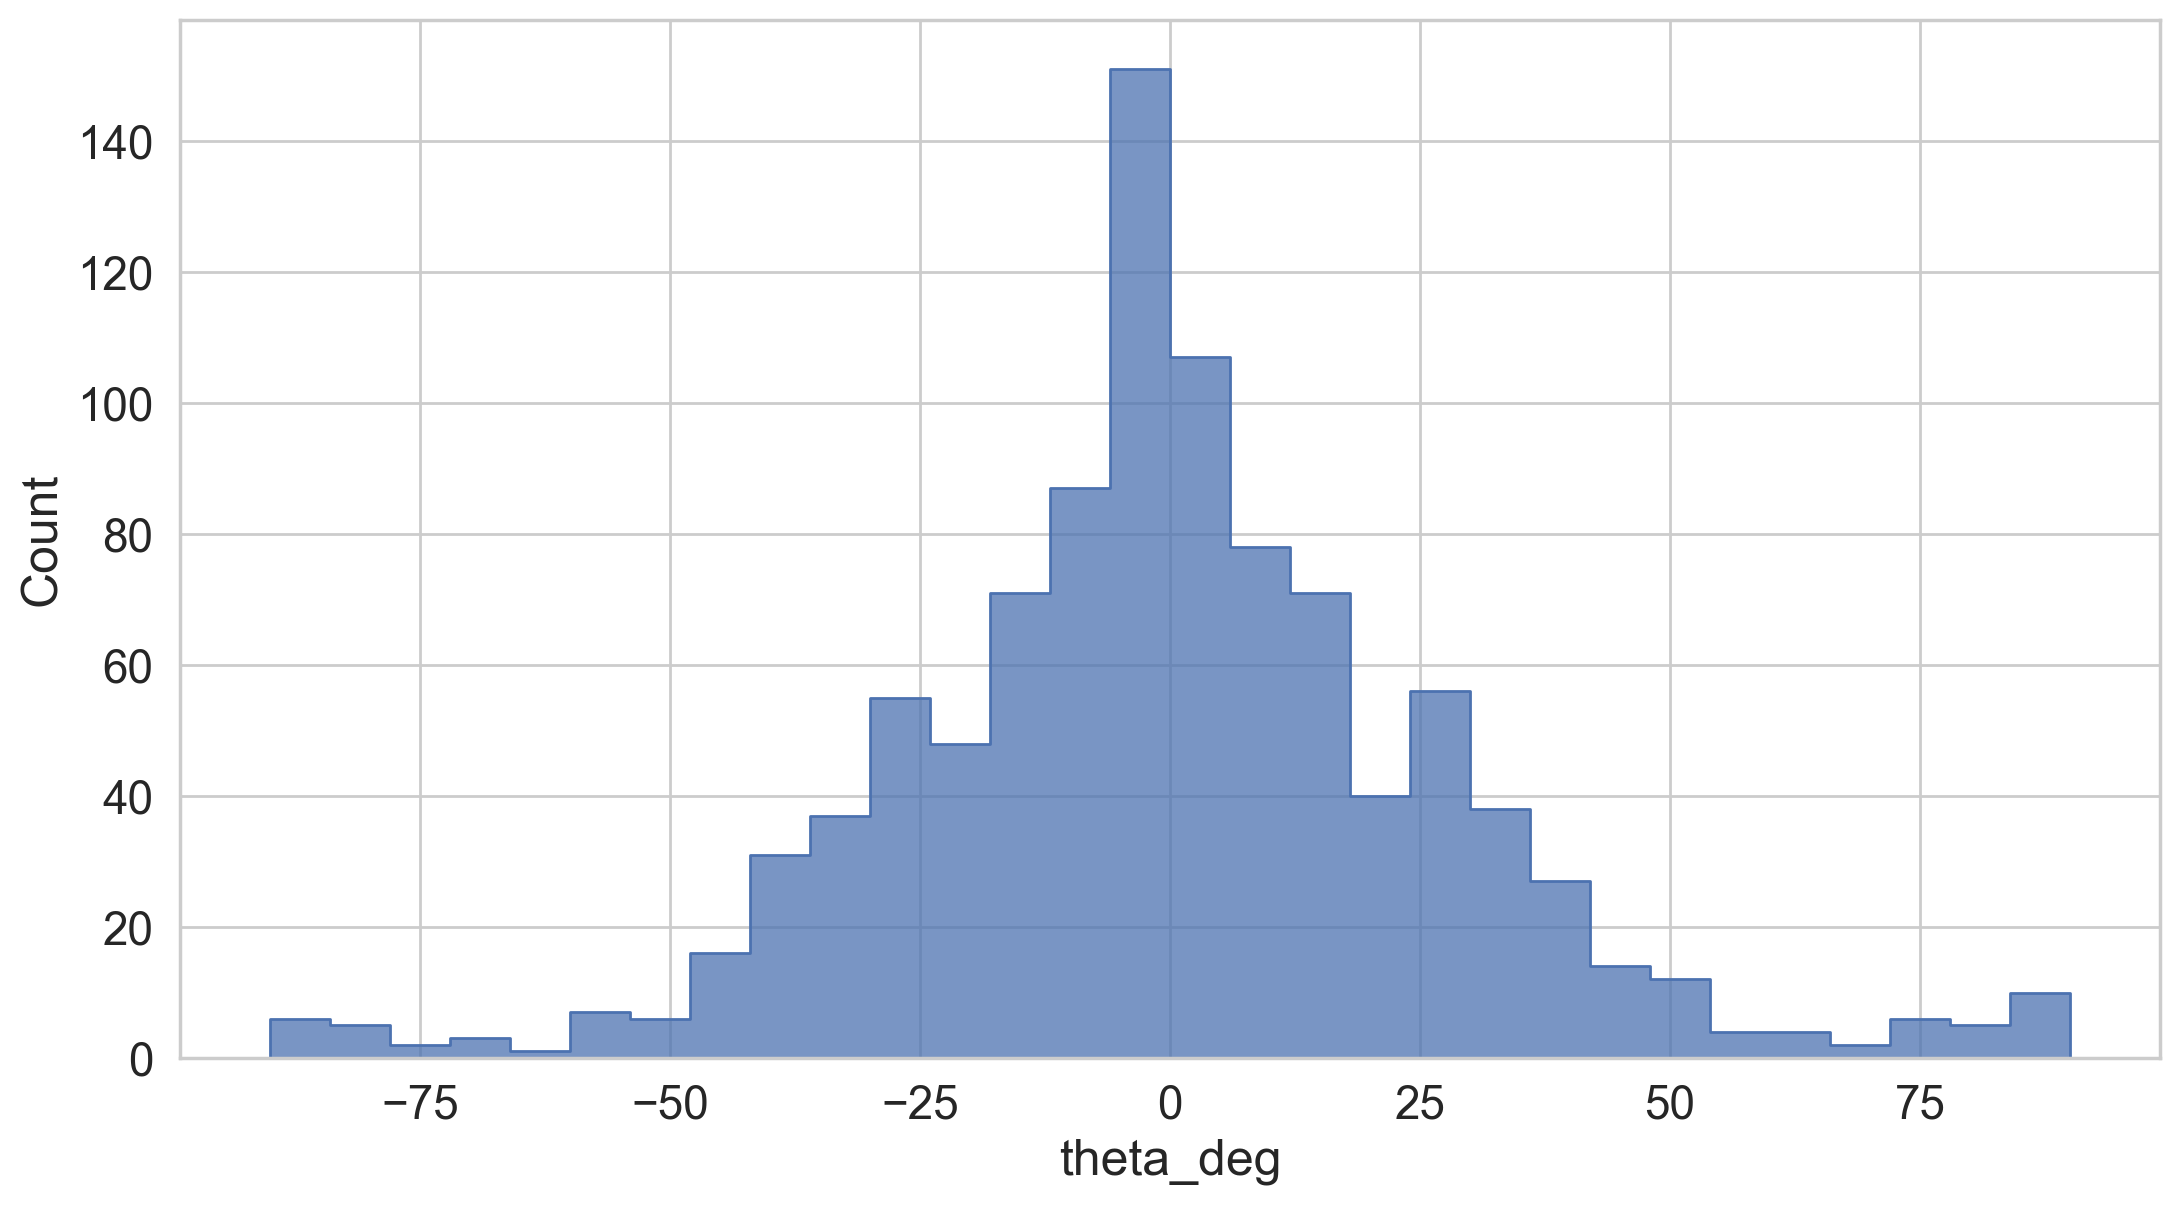

In [86]:
sns.histplot(
    data=gaussian_df,
    x='theta_deg',
    bins=30,
    element='step'  # Use step plots for clarity
)


Interpretation:

* θ=0: The major axis is aligned with the x-axis.
* θ=π/2: The major axis is aligned with the y-axis.
* θ=π/4: The major axis is at a 45° angle.
